In [1]:
from ant_array2 import RadioArray
from allsky_viewer import AllSkyViewer, generate_skycat
from astropy.time import Time
import ephem
import numpy as np
import pylab as plt
import h5py
import hickle as hkl
from astropy.coordinates import SkyCoord
from coord_utils import skycoord_to_ephem

### Load FITS data

In [2]:
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'
filename_ant  = 'eda_antenna_locations_v2.h5'
# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')
sun = ephem.Sun()

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t.datetime, verbose=True, phase_center=sun)
eda.load_fits_data(filename_data)

Time: 2020/2/9 03:46:46
Sun 	RA / DEC:  (21:29:01.23, -14:51:39.7) 
	ALT / AZ:  (74:49:40.3, 40:43:47.7)
ZENITH: (20:47:08.87, -26:46:33.5)
HA, D: (-0.18270382264997043, -14:51:39.7)


In [3]:
img = eda.make_image()
sun.compute(eda)

/Users/dancpr/Data/eda_post_x/ant_array2.py:161: RuntimeWarning: invalid value encountered in sqrt
  ng     = np.sqrt(1 - lg**2 - mg**2)


### Test all-sky imshow

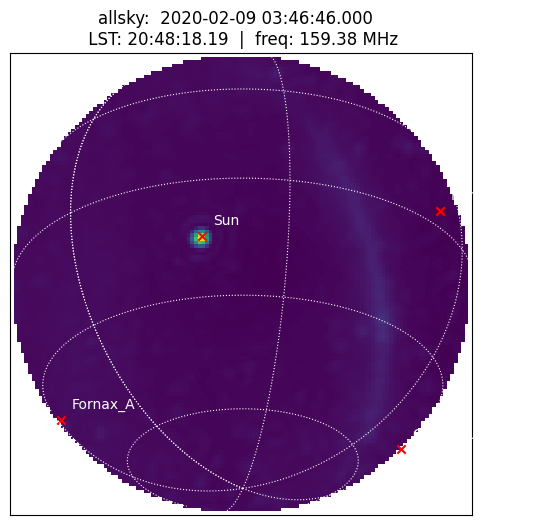

In [4]:
asv = AllSkyViewer(observer=eda, ts=t, f_mhz=f_mhz[0], n_pix=128)
skycat = generate_skycat(asv.observer)
asv.load_skycat(skycat)

asv.new_fig(6)
asv.plot(img, overlay_srcs=True)

### Test HDF5 load

In [8]:
h5_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_chunked_2020.05.20.h5'
h5_metadata_path = 'imaging_metadata_2022.11.14.hkl'
md = hkl.load(h5_metadata_path)

t = Time(md['time'], format='jd')
f_mhz = md['freqs'] / 1e6

sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=False, 
                 phase_center=sun, conjugate_data=True)

eda.load_h5_data(h5_path)

In [48]:
img = eda.make_image()

/Users/dancpr/Data/blink/ant_array2.py:131: RuntimeWarning: invalid value encountered in sqrt
  ng     = np.sqrt(1 - lg**2 - mg**2)


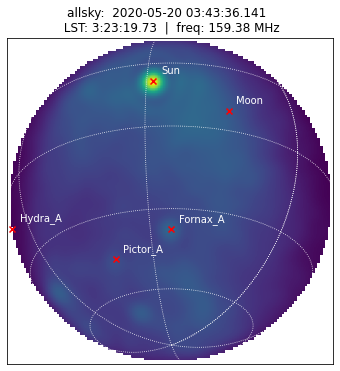

In [49]:
asv.new_fig(6)
asv.ts = t[0]
asv.plot(img, overlay_srcs=True)

### Beamform toward sun and calibrators

In [17]:
eda.verbose = False
sun.compute(eda)
moon = ephem.Moon()
moon.compute(eda)

h5_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_chunked_2020.05.20.h5'
md = hkl.load('imaging_metadata_2022.11.14.hkl')
t = Time(md['time'], format='jd')
f_mhz = md['freqs'] / 1e6
sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=False, 
                 phase_center=sun, conjugate_data=True)
eda.load_h5_data(h5_path)
sc = SkyCoord(md['ra'], md['dec'], unit=('degree', 'degree'))

N = 11200

beams_xx = {
    'Sun': np.zeros((N, 4, 4), dtype='float32'),
    'Moon':  np.zeros((N, 4, 4), dtype='float32'),
    'Fornax_A':  np.zeros((N, 4, 4), dtype='float32'),
    'Pictor_A':  np.zeros((N, 4, 4),dtype='float32')
}

beams_yy = {
    'Sun': np.zeros((N, 4, 4), dtype='float32'),
    'Moon':  np.zeros((N, 4, 4), dtype='float32'),
    'Fornax_A':  np.zeros((N, 4, 4), dtype='float32'),
    'Pictor_A':  np.zeros((N, 4, 4),dtype='float32')
}

for ii in range(N):
    if ii % 100 == 0: print(f'{ii}/{N}')
    ts = t[ii]
    
    phase_center = skycoord_to_ephem(sc[ii])
    eda.phase_center = phase_center
    
    eda.update(date=ts.datetime, f_idx=ii, pol_idx=0)
    sun.compute(eda)
    moon.compute(eda)
    beams_xx['Sun'][ii]  = eda.beamform(sun)
    beams_xx['Moon'][ii] = eda.beamform(moon)
    beams_xx['Fornax_A'][ii] = eda.beamform(skycat['Fornax_A'])
    beams_xx['Pictor_A'][ii] = eda.beamform(skycat['Pictor_A'])

    eda.update(date=ts.datetime, f_idx=ii, pol_idx=1)
    beams_yy['Sun'][ii]  = eda.beamform(sun)
    beams_yy['Moon'][ii] = eda.beamform(moon)
    beams_yy['Fornax_A'][ii] = eda.beamform(skycat['Fornax_A'])
    beams_yy['Pictor_A'][ii] = eda.beamform(skycat['Pictor_A'])

beams_xx['f_mhz'] = f_mhz
beams_yy['f_mhz'] = f_mhz

0/11200
100/11200
200/11200
300/11200
400/11200
500/11200
600/11200
700/11200
800/11200
900/11200
1000/11200
1100/11200
1200/11200
1300/11200
1400/11200
1500/11200
1600/11200
1700/11200
1800/11200
1900/11200
2000/11200
2100/11200
2200/11200
2300/11200
2400/11200
2500/11200
2600/11200
2700/11200
2800/11200
2900/11200
3000/11200
3100/11200
3200/11200
3300/11200
3400/11200
3500/11200
3600/11200
3700/11200
3800/11200
3900/11200
4000/11200
4100/11200
4200/11200
4300/11200
4400/11200
4500/11200
4600/11200
4700/11200
4800/11200
4900/11200
5000/11200
5100/11200
5200/11200
5300/11200
5400/11200
5500/11200
5600/11200
5700/11200
5800/11200
5900/11200
6000/11200
6100/11200
6200/11200
6300/11200
6400/11200
6500/11200
6600/11200
6700/11200
6800/11200
6900/11200
7000/11200
7100/11200
7200/11200
7300/11200
7400/11200
7500/11200
7600/11200
7700/11200
7800/11200
7900/11200
8000/11200
8100/11200
8200/11200
8300/11200
8400/11200
8500/11200
8600/11200
8700/11200
8800/11200
8900/11200
9000/11200
9100/11200


In [228]:
eda.update?

Signature: eda.update(date=None, f_idx=None, pol_idx=0, update_gsm=False)
Docstring: <no docstring>
File:      ~/Data/eda_post_x/ant_array2.py
Type:      method


### Test PFB overlap

In [12]:
def overlap(x):
    N_fine    = 32
    N_overlap = 3
    N_coarse  = 350
    N_sel = N_fine - N_overlap*2 +1
    ch0 = x[N_overlap:N_fine-N_overlap]
    chs = []
    
    for ii in range(1, N_coarse):
        ch = x[ii*N_fine:(ii+1)*N_fine]
        chs.append(ch[N_overlap-1:-N_overlap])
    return np.concatenate(chs)

In [15]:
f_over = overlap(f_mhz)
b_sun = overlap(beams_xx['Sun'] + beams_yy['Sun'])
b_pic = overlap(beams_xx['Pictor_A']+ beams_yy['Sun'])
b_fnx = overlap(beams_xx['Fornax_A']+ beams_yy['Sun'])
b_moon = overlap(beams_xx['Moon']+ beams_yy['Sun'])

tmask = md['time'] > md['time'][0] - 2
tmask = overlap(tmask)

In [ ]:
%matplotlib widget
import bottleneck as bn

def find_closest(x, x0):
    return np.argmin(np.abs(x-x0))

d = b_pic / b_fnx
m = bn.move_median(d, 64)
d = np.ma.array(d)
d.mask =  np.abs(d - m) > 5
d.mask = np.logical_or(d.mask, ~tmask)

masks = [
    [243, 244.3],
    [244.7, 245],
    [246.1, 246.5],
    [248, 271],
    [103, 108.5],
    [100.2, 100.4],
    [146, 147],
    [137, 137.2],
    [346, 346.3],
    [346.7, 348],
    [349.6, 350.2]
    ]

for m in masks:
    i0 = find_closest(m[0], f_over)
    i1 = find_closest(m[1], f_over)
    d.mask[i0:i1] = True


plt.clf()
plt.plot(f_over, d)
#plt.ylim(0.8, 1.2)
#plt.plot(f_over, b_fnx/b_moon)

### Plotting widget

In [191]:
h5_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_chunked_2020.05.20.h5'
md = hkl.load('imaging_metadata_2022.11.14.hkl')

t = Time(md['time'], format='jd')
f_mhz = md['freqs'] / 1e6

sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=False, 
                 phase_center=sun, conjugate_data=True)

eda.load_h5_data(h5_path)

sc = SkyCoord(md['ra'], md['dec'], unit=('degree', 'degree'))

In [180]:
s

<ephem.FixedBody '' at 0x7fb2a0845030>

In [179]:
sc[0]

<SkyCoord (ICRS): (ra, dec) in deg
    (57.10742, 20.0015)>

9:07:34.58 19:55:15.6


In [193]:
def run_imager(f_mhz, t, sc, idxs, n_pix=129):
    
    for idx in idxs:
        phase_center = skycoord_to_ephem(sc[idx])
        
        eda.phase_center = phase_center
        for p_idx in (0,1,2,3):
            print(f"generating F {idx} P {p_idx}")
            eda.update(date=t[idx].datetime, f_idx=idx, pol_idx=p_idx)
            img = eda.make_image()
            hkl.dump(img, f'dask-out2/img-f{idx}-p{p_idx}.hkl')
    return "ok"
            

In [218]:
run_imager(f_mhz, t, sc, [1000])

generating F 1000 P 0
generating F 1000 P 1
generating F 1000 P 2
generating F 1000 P 3


'ok'

In [222]:
avs

NameError: name 'avs' is not defined

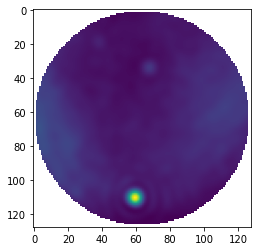

In [221]:
%matplotlib inline
img = hkl.load('dask-out2/img-f1000-p1.hkl')
plt.imshow(img)

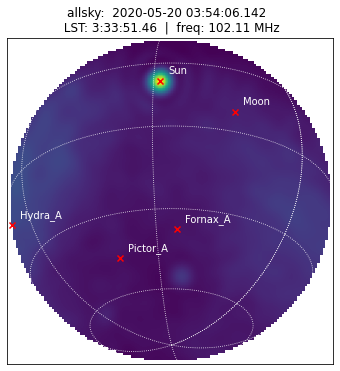

In [226]:
asv = AllSkyViewer(observer=eda, ts=t[1000], f_mhz=f_mhz[1000], n_pix=128)
skycat = generate_skycat(asv.observer)
asv.load_skycat(skycat)

asv.new_fig(6)
asv.plot(img, overlay_srcs=True)

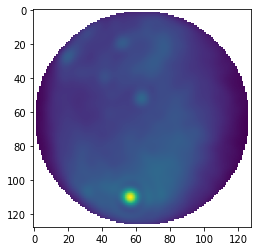

In [165]:
plt.imshow(img)

In [189]:
from astropy.coordinates import SkyCoord

def skycoord_to_ephem(x, name='', flux=1, epoch=2000):
    ra  = x.ra.to('hourangle').to_string(sep=':')
    dec = x.dec.to_string(sep=':')
    line = "%s,f,%s,%s,%s,%d"%(name,ra,dec,flux,epoch)
    body = ephem.readdb(line)
    return body

def ephem_to_skycoord(x):
    s = SkyCoord(x._ra, x._dec, unit=('rad', 'rad'))
    return s

def test_ephem_skycoord(sc_array):
    for ii in range(len(sc_array)):
        _e0 = skycoord_to_ephem(sc[ii])
        _s0 = ephem_to_skycoord(_e0)
        assert np.isclose(_s0.ra, sc[ii].ra)
        assert np.isclose(_s0.dec, sc[ii].dec)

test_ephem_skycoord(sc[:10])  

In [190]:
s = skycoord_to_ephem(sc[0])
s.compute(eda)
print(s.ra, s.dec)

3:49:34.14 20:03:37.9


In [186]:
sc[0].ra.to_string(

<Longitude 57.10742 deg>